# Cvičení 03 - rozhodovací stromy pro regresi

Klasifikace versus regrese 

- **Klasifikace**:  V předchozím cvičení jsme zkoušeli natrénovat model, který z demografických údajů predikuje zda příjem člověka přesáhne 50000 USD ročně.
    - Predikovali jsme tedy veličinu která náleží do diskrétní množiny (přesáhne/nepřesáhne), $y \in \{0, 1\}$. 
- **Regrese**:  V tomto cvičení se zaměříme na predikci spojité hodnoty kterou představuje cena domu
    - Problém, ve kterém predikujeme spojitou veličinu, označujeme jako problém regrese.

Jak víme z přednášky, rozhodovací stromy lze využít jak pro klasifikaci, tak pro regresi! 🚀

## Dataset 🏘️
- V tomto notebooku využijeme další populární dataset z [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
- Jedná se o údaje o domech a jejich prodejních cenách. Cílem je předpovědět **cenu domu** (příznak **SalePrice**) na základě celkem 79 příznaků.

Popis jednotlivých dat i jednotlivých příznaků se nachází v souboru `data_description.txt`.

```python
# Show the data description
!cat data_description.txt
```

![https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)
*zdroj obrázku: [https://www.kaggle.com/c/house-prices-advanced-regression-techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)*

In [18]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

random_seed = 42

# Příprava dat
Otevřeme si dataset a podívejme se co obsahuje.

In [19]:
df = pd.read_csv('house-prices-train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podívejme se na rozdělení cílové proměnné **SalePrice**.

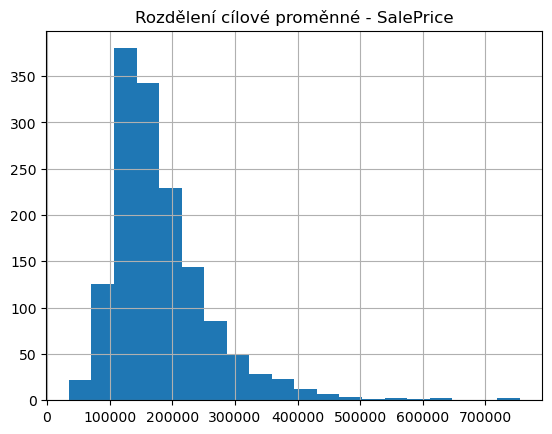

In [21]:
df.SalePrice.hist(bins=20)
plt.title("Rozdělení cílové proměnné - SalePrice")
plt.show()

### Příprava datasetu pro použití modelu

Opět vidíme, že v datasetu existuje spousta nečíselných příznaků a příznaků, které mají chybějící hodnoty. Nejprve tedy musíme provést základní předzpracování.

**Krok 1**: Převedeme textové příznaky (`dtype = object`) na příznaky kategoriální.
- Zkusme nejprve nastavit jejich typ na *kategoriální* (`dtype = category`). Pandas si pak tyto příznaky interně ukládá jako číselné.
- Jako kategoriální lze chápat pouze příznaky *s ne moc různými hodnotami* (např. jméno není vhodné).
- V našem případě lze brát jako kategoriální všechny textové příznaky.

```python
# Zkonvertujeme sloupce typu object na typ category
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')
```

Interně takto získáne vhodnou reprezentaci, ale pro použití modelu ještě musíme provést další krok, protože implementace ve `scikit-learn` nepodporuje `dtype = category`.

**Krok 2**: Kategoriální proměnné nahradíme čísly.
- Pro řazené kategoriální příznaky (tzv. **ordinální**) stačí použít interní číslování kategorií, které dostaneme pomocí `...cat.codes`.
- Pro ty neřazené (**nominální**) je tento přístup poněkud nešťastný (čísla seřazená vždycky jsou).
- U nominálních příznaků je lépe využít **one-hot encoding**. To je reprezentace, kdy daný příznak nahradíme mnoha novými binárními tzv. **dummy**  příznaky reprezentujícími příslušnost k každé z kategorií.
    
Rozhodnutí, který příznak je nominální a který ordinální, lze stěží automatizovat a je nutné postupovat ručně. Dobrým kandidátem pro ordinální příznak je *KitchenQual*. 

In [22]:
display(df.KitchenQual.unique())

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Dle popisu v souboru `data_description.txt`: Ex = Excellent, Gd = Good, TA = Typical/Average, Fa = Fair, Po = Poor. Takže bychom chtěli tyto textové hodnoty nahradit čísly tak, aby se zachovalo pořadí Po < Fa < TA < Gd < Ex. Při prvotním převodu na kategorickou proměnnou tedy řekneme, že se jedná o uspořádané kategorie a zadáme je ve správném pořadí.

In [23]:
print("Příznak KitchenQual před změnou typu:")
display(df.KitchenQual.sample(5, random_state=random_seed))

qual_category = pd.api.types.CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)

df.KitchenQual = df.KitchenQual.astype(qual_category)

print("Příznak KitchenQual po změně typu:")
display(df.KitchenQual.sample(5, random_state=random_seed))

Příznak KitchenQual před změnou typu:


892     TA
1105    Gd
413     TA
522     TA
1036    Ex
Name: KitchenQual, dtype: object

Příznak KitchenQual po změně typu:


892     TA
1105    Gd
413     TA
522     TA
1036    Ex
Name: KitchenQual, dtype: category
Categories (5, object): ['Po' < 'Fa' < 'TA' < 'Gd' < 'Ex']

Nyní si můžeme všimnout, že nejenom *KitchenQual*, ale i další příznaky končící na **Qual** nebo **Qu** nebo **QC** nebo **Cond** mají hodnoty ze stejné škály a á tedy smysl je reprezentovat stejným způsobem.

### ÚKOL: Reprezentujte všechny takové příznaky jako category type. 

In [24]:
## Váš kód zde
for col in df.select_dtypes('object').columns:
    if col.endswith("Qual") or col.endswith("Qu") or col.endswith("QC") or col.endswith("Cond"):
        print(col, df[col].unique())
        df[col] = df[col].astype(qual_category)
        
df.head()

ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond ['TA' 'Gd' nan 'Fa' 'Po']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
FireplaceQu [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
PoolQC [nan 'Ex' 'Fa' 'Gd']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1201 non-null   float64 
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          91 non-null     object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

Před kodováním zbytku příznaků typu **object** pomocí **one-hot encoding** si ty stávající categoriální převedeme na číselnou reprezentaci.

In [26]:
for col in df.select_dtypes('category').columns:
    df[col] = df[col].cat.codes

U ostatních nečíselných příznaků budeme předpokládat, že se jedná o **nominální** příznaky a převedeme je na **one-hot encoding** reprezentaci. K tomu můžeme využít metodu `get_dummies()` z `pandas`. Udělejme to nejprve nejpřímějším způsobem a později budeme diskutovat limity tohoto přístupu.

In [27]:
df = pd.get_dummies(df)

In [28]:
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,3,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,2,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,3,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,2,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,3,...,0,0,0,1,0,0,0,0,1,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 256 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(35), int8(10), uint8(208)
memory usage: 744.4 KB


In [30]:
list(df.columns)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utili

Na závěr nahradíme všechny chybějící hodnoty -1.

In [31]:
df = df.fillna('-1')

## Rozdělení dat

Adresář obsahuje CSV soubory `house-prices-train.csv` a `house-prices-test.csv`. `house-prices-test.csv` použijeme později. Pro naše účely použijeme pouze `house-prices-train.csv` a rozdělíme ho na **trénovací**, **validační** a **testovací** množinu.

In [32]:
from sklearn.model_selection import train_test_split

# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, ytrain, yrest = train_test_split(
    df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

# Rozhodovací stromy pro regresi
V minulém cvičení jsme viděli rozhodovací stromy pro klasifikaci. Nyní si ukážeme, jejich regresní verzi.

### Trénovací kritéria
Jako optimalizační kritérium při konstrukci rozhodovacího stromu pro klasifikaci byla použita entropie nebo Gini index. Jako optimální dělící kritérium určené příznakem a thresholdem se vzala taková dvojice, která odpovídala největšímu informačnímu zisku, který představoval rozdíl hodnoty před rozdělením a váženého průměru hodnot po rozdělení.

V případě regresní úlohy chceme, aby po rozdělení došlo ke snížení *rozptylu* hodnot v jednotlivých větvích.
Jako míru *rozptylování* nejčastěji bereme MSE příp. MAE definované jako:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (Y_i - \bar Y)^2\quad \text{resp.}\quad \text{MAE} = \frac{1}{n} \sum_{i=1}^n |Y_i - \bar Y|.
$$

Jako optimální dělení množiny $\mathcal D$ pak bereme dělení na části $\mathcal{D}_1$ a $\mathcal{D}_2$, která maximalizuje kritérium
$$
 J = \text{MSE}(\mathcal{D}) - t_1 \text{MSE}(\mathcal{D}_1) - t_2 \text{MSE}(\mathcal{D}_2),
$$
kde $t_1 = \frac{\#\mathcal{D}_1}{\#\mathcal{D}}$.

### Vyhodnocovací metriky
V případě klasifikace jsme používali accuracy (kolik dat model predikoval správně). Nyní ovšem predikujeme spojitou proměnnou. Jak říct o výsledku, že je správně? Budeme měřit, jak daleko od kýženého výsledku se model strefil! Často používané metriky pro měření kvality regresního modelu jsou:

Název | Vzorec
----- | -------
MSE   | $$\frac{1}{n}\sum_{i=1}^{n}(Y_{i} - \hat{Y}_{i})^2$$
RMSE   | $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(Y_{i} - \hat{Y}_{i})^2}$$
MAE   | $$\frac{1}{n}\sum_{i=1}^{n}|Y_{i} - \hat{Y}_{i}|$$
RMSLE | $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(Y_{i} + 1) - log(\hat{Y}_{i} + 1))^2}$$

Výběr správné metriky je extrémně podstatný úkol, který může zásadním způsobem ovlivnit, který model vybereme jako finální. Musíme si dát pozor, aby metrika správně reflektovala vlastnosti modelu, které jsou pro nás důležité (např. aby se soustředila na odlhelé hodnoty, nebo napak aby je částečně ignorovala). Často bohužel naše metrika neodpovídá přesně tomu, čeho chceme dosáhnout (ono to často ani přesně nevíme). Jednotlivé metriky se liší v mnoha směrech:
- jak je můžeme interpretovat (co vyjadřují)
- jak snadno je (ne)lze zderivovat
- jak se chovají pro různá data (outliers)

Například pro zmíněné metriky
- MSE a RMSE je citlivé na outliers (penalizuje je hodně)
- MAE se dá snadno interpretovat, méně citlivé na outliers
- RMSLE je citlivé na malé odchylky a relativně necitlivé k outliers

### Použití rozhodovacího stromu

Pro klasifikaci jsme používali `DecisionTreeClassifier`, pro regresi využijeme jeho variantu `DecisionTreeRegressor`.

Na měření výkonnosti využijeme `mean_squared_error`.

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Zkusíme rovnou různé hloubky stromu a porovnáme jejich validační chybu měřenou pomocí RMSE.

In [34]:
depths = range(1,10)

val_metric = []
for depth in depths:
    clf = DecisionTreeRegressor(max_depth = depth).fit(Xtrain, ytrain)
    val_metric.append(mean_squared_error(yval, clf.predict(Xval), squared = False))

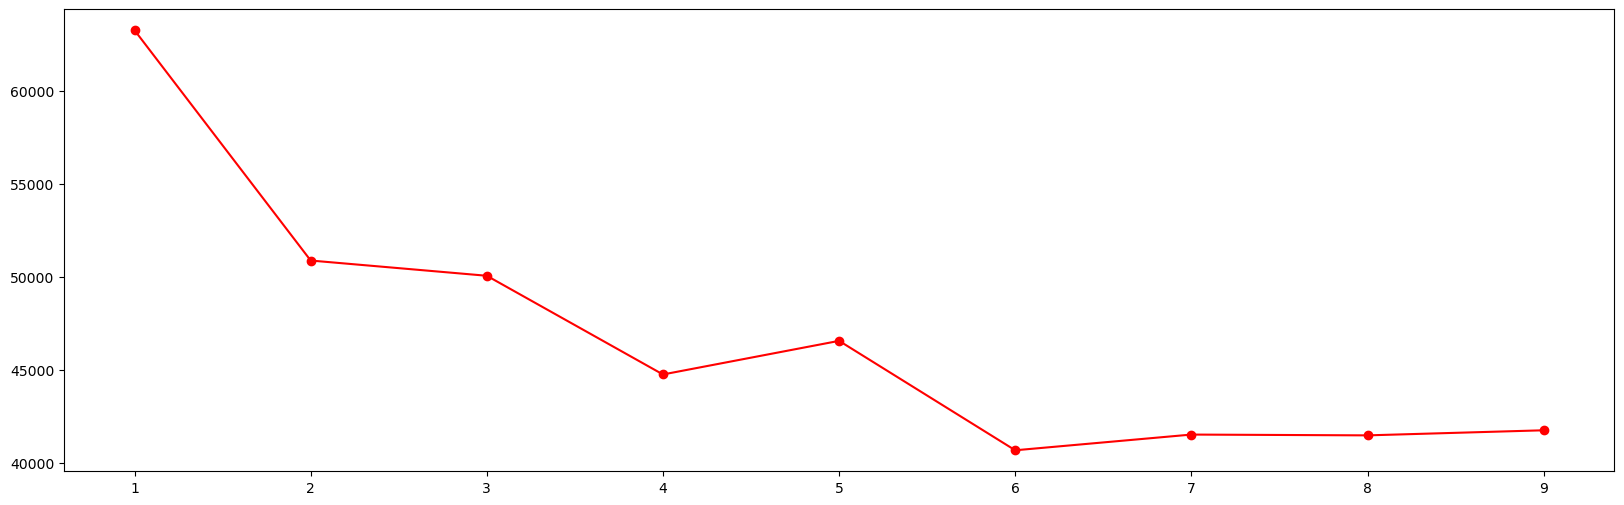

In [35]:
plt.figure(figsize=(20,6))
plt.plot(depths, val_metric,'or-') #o: body, r: barva, -: spojení bodů linkou

In [36]:
val_metric

[63277.84997726498,
 50880.67796055507,
 50059.68152607927,
 44745.926870905976,
 46555.536382513565,
 40663.765293929006,
 41509.60794869996,
 41466.57327782632,
 41740.23759220042]

Zkusíme se podívat, jak vypadá predikce pro nejlepší

In [37]:
# Vybereme nejlepší parametry
best_depth = depths[np.argmin(val_metric)]
print(f"We found the best depth {best_depth} with validation RMSE {min(val_metric):.4f}.")

# Natrénujeme na nich DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth = best_depth).fit(Xtrain, ytrain)

We found the best depth 6 with validation RMSE 40663.7653.


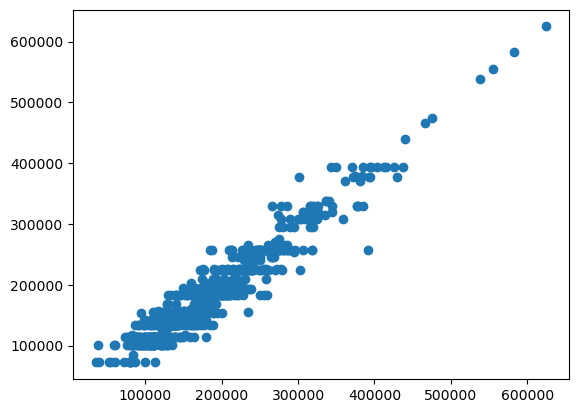

In [38]:
plt.scatter(ytrain, clf.predict(Xtrain))

In [39]:
train_rmse_tree = mean_squared_error(ytrain, clf.predict(Xtrain), squared = False)
valid_rmse_tree = mean_squared_error(yval, clf.predict(Xval), squared = False)
print(f"RMSE (train): \t{train_rmse_tree:.4f}")
print(f"RMSE (valid): \t{valid_rmse_tree:.4f}")

RMSE (train): 	22412.9759
RMSE (valid): 	42882.8134


```python
# Na chybu na testovacích date se dívat nebudeme! 
# Na trénovacích datech ještě chceme trénovat další modely!
test_rmse_tree = rmsle(ytest, dt.predict(Xtest))
print(f"RMSE (test): \t{test_rmse_tree:.4f}")
```

## Úkol: zkuste, jak by byl model výkonný bez využití get_dummies

Využije `LabelEncoder` ze `sklearn.preprocessing` pro získání číselné reprezentace místo převodu na kategorické a použití `...cat.codes`.

In [ ]:
# Váš kód zde.
df = pd.read_csv('house-prices-train.csv')

qual_category = pd.api.types.CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
df.KitchenQual = df.KitchenQual.astype(qual_category)
df.KitchenQual = df.KitchenQual.cat.codes

from sklearn.preprocessing import LabelEncoder
for col in df.select_dtypes('object').columns:
    label_encoder = LabelEncoder()
    df[col] = df[col].fillna('NaN')
    df[col] = label_encoder.fit_transform(df[col])

df = df.fillna('-1')

# Split the training dataset into 60% train
Xtrain, Xrest, ytrain, yrest = train_test_split(
    # Training columns except target, target values , magic constant, keep our output consitent
    df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed
)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6, random_state=random_seed
)

depths = range(1,10)

val_metric = []
for depth in depths:
    clf = DecisionTreeRegressor(max_depth = depth).fit(Xtrain, ytrain)
    val_metric.append(mean_squared_error(yval, clf.predict(Xval), squared = False))
    
val_metric

## Vyhodnocení pomocí RMSLE

Posledním úkolem je zkusit, jak Váš model obstojí v soutěži na Kaggle. Vyhodnocení je zde prováděno pomocí metriky RMSLE, kterou si nejdříve naimplementujme.

In [ ]:
def rmsle(y_true: pd.Series, y_hat: pd.Series) -> float:
    return math.sqrt(
        metrics.mean_squared_error(
            np.log1p(y_true), np.log1p(y_hat)
        )
    )

In [ ]:
print(f"Validační RMSLE: {rmsle(yval, clf.predict(Xval))}")

## Úkol: Zkuste snížit RMSLE jak to jen jde s využitím dalších hyperparametrů a nahrát svoje řešení na Kaggle

Využijte opět `ParameterGrid`.

Stránka pro odevzdání: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit

In [ ]:
train = pd.read_csv('house-prices-train.csv')
test = pd.read_csv('house-prices-test.csv')

Kaggle při odevzdání počítá s CSV souborem, který má 2 sloupce `Id` a `SalePrice`. 

Příklad souboru který projde odevzdáním:

|   Id |   SalePrice |
|-----:|------------:|
| 1461 |      112317 |
| 1462 |      132388 |
| 1463 |      156409 |
| 1464 |      172197 |
| 1465 |      179526 |

Při ukládání můžete využít parametr `index=False` pro ignorování indexu.

```python
df.to_csv('kaggle_submission.csv', index=False)
```

In [ ]:
# Váš kód zde
